# Проект e-commerce:

Продакт-менеджер попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

5. Напиши функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц.

6. Построй RFM-кластеры для пользователей. Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M).

Файлы:

**olist_customers_datase.csv** — таблица с уникальными идентификаторами пользователей

_customer_id_ — позаказный идентификатор пользователя (аналог номера паспорта)

_customer_unique_id_ —  уникальный идентификатор пользователя

_customer_zip_code_prefix_ —  почтовый индекс пользователя

_customer_city_ —  город доставки пользователя

_customer_state_ —  штат доставки пользователя

\
**olist_orders_dataset.csv** —  таблица заказов

_order_id_ —  уникальный идентификатор заказа (номер чека)

_customer_id_ —  позаказный идентификатор пользователя (аналог номера паспорта)

_order_status_ —  статус заказа

_order_purchase_timestamp_ —  время создания заказа

_order_approved_at_ —  время подтверждения оплаты заказа

_order_delivered_carrier_date_ —  время передачи заказа в логистическую службу

_order_delivered_customer_date_ —  время доставки заказа

_order_estimated_delivery_date_ —  обещанная дата доставки


\
**olist_order_items_dataset.csv** —  товарные позиции, входящие в заказы

_order_id_ —  уникальный идентификатор заказа (номер чека)

_order_item_id_ —  идентификатор товара внутри одного заказа

_product_id_ —  ид товара (аналог штрихкода)

_seller_id_ — ид производителя товара

_shipping_limit_date_ —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

_price_ —  цена за единицу товара

_freight_value_ —  вес товара


\
Уникальный статусы заказов в таблице olist_order_items_dataset:

_created_ —  создан

_approved_ —  подтверждён

_invoiced_ —  выставлен счёт

_processing_ —  в процессе сборки заказа

_shipped_ —  отгружен со склада

_delivered_ —  доставлен пользователю

_unavailable_ —  недоступен

_canceled_ —  отменён

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

from operator import attrgetter
import warnings

In [2]:
# Загрузка датафрейма с покупателями
customers = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/0PogWY7zE_YjMw')

In [3]:
customers.head(10)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC
6,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,sao paulo,SP
7,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,timoteo,MG
8,5adf08e34b2e993982a47070956c5c65,1175e95fb47ddff9de6b2b06188f7e0d,81560,curitiba,PR
9,4b7139f34592b3a31687243a302fa75b,9afe194fb833f79e300e37e580171f22,30575,belo horizonte,MG


In [4]:
# Размер датафрейма
customers.shape

(99441, 5)

In [5]:
# Типы данных
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [6]:
# Проверка на пустые значения
customers.isnull().any() 

# пустых значений нет

customer_id                 False
customer_unique_id          False
customer_zip_code_prefix    False
customer_city               False
customer_state              False
dtype: bool

In [7]:
# Загрузка датафрейма с заказами
orders = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/VoEqHYny8rnG6g',
                   parse_dates=['order_purchase_timestamp', 
                                'order_approved_at', 
                                'order_delivered_carrier_date', 
                                'order_delivered_customer_date', 
                                'order_estimated_delivery_date'], 
                   infer_datetime_format=True)

In [8]:
orders.head(10)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06
9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23


In [9]:
# Размер датафрейма
orders.shape

(99441, 8)

In [10]:
# Типы данных
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [11]:
# Проверка на пустые значения
orders.isnull().any() 

# в 3-х столбцах есть пустые значения

order_id                         False
customer_id                      False
order_status                     False
order_purchase_timestamp         False
order_approved_at                 True
order_delivered_carrier_date      True
order_delivered_customer_date     True
order_estimated_delivery_date    False
dtype: bool

In [15]:
# Загрузка датафрейма с товарами
goods = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/XsuklUD5HhAnVg',
                   parse_dates=['shipping_limit_date'], 
                   infer_datetime_format=True)

In [16]:
goods.head(10)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
5,00048cc3ae777c65dbb7d2a0634bc1ea,1,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,2017-05-23 03:55:27,21.90,12.69
6,00054e8431b9d7675808bcb819fb4a32,1,8d4f2bb7e93e6710a28f34fa83ee7d28,7040e82f899a04d1b434b795a43b4617,2017-12-14 12:10:31,19.90,11.85
7,000576fe39319847cbb9d288c5617fa6,1,557d850972a7d6f792fd18ae1400d9b6,5996cddab893a4652a15592fb58ab8db,2018-07-10 12:30:45,810.00,70.75
8,0005a1a1728c9d785b8e2b08b904576c,1,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,145.95,11.65
9,0005f50442cb953dcd1d21e1fb923495,1,4535b0e1091c278dfd193e5a1d63b39f,ba143b05f0110f0dc71ad71b4466ce92,2018-07-06 14:10:56,53.99,11.40


In [17]:
# Размер датафрейма
goods.shape

(112650, 7)

In [18]:
# Типы данных
goods.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [19]:
#перевод столбца shipping_limit_date в формат даты
goods['shipping_limit_date'] = pd.to_datetime(goods['shipping_limit_date'], format="%Y-%m-%d %H:%M:%S")

In [20]:
# Проверка на пустые значения
goods.isnull().any()

# пустых значений нет

order_id               False
order_item_id          False
product_id             False
seller_id              False
shipping_limit_date    False
price                  False
freight_value          False
dtype: bool

# Задние 1

In [21]:
# Объеденяем таблицы customers и orders по столбцу customer_id
customer_orders = customers.merge(orders, how='inner', on='customer_id')

In [22]:
# отбираем все заказы у которых статус НЕ равен "created" или "canceled"
approved_customer_orders = customer_orders.query('order_status not in ["created", "canceled"]')
approved_customer_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [23]:
# считаем количество заказов для каждого пользователя
count_customer_orders = approved_customer_orders.groupby('customer_unique_id', as_index=False).agg({'order_id':'count'})
# переименуем столбец с полученными результатами
counts_of_purchases = count_customer_orders.rename(columns={'order_id': 'number_of_orders'})
counts_of_purchases.head()

,customer_unique_id,number_of_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [24]:
# Подсчитаем количество покупателей которые совершили покупку только один раз
counts_of_purchases.query('number_of_orders == 1').value_counts('number_of_orders')

number_of_orders
1    92633
dtype: int64

# Ответ на 1 задание: 
**92633** пользователей совершили покупку только один раз

# Задание 2

In [25]:
# Отбираем все заказы у которы хнет статуса "delivered"
orders_not_delivered = orders.query('order_status != "delivered" ')

In [26]:
# Раазмер датафрейма
orders_not_delivered.shape

(2963, 8)

In [27]:
# хоть и кривым, но зато рабочим методом приводим колонку 'order_purchase_timestamp' к виду год-месяц
orders_not_delivered_by_month = orders_not_delivered.set_index('order_purchase_timestamp') \
                                                                                        .to_period('M') \
                                                                                        .sort_index() \
                                                                                        .reset_index()

In [28]:
# Считаем количество неодоставленных заказов по месяцам
count_orders_not_delivered_by_month = orders_not_delivered_by_month.groupby('order_purchase_timestamp') \
                                                                    .agg({'order_status': 'count'})
count_orders_not_delivered_by_month.head(5)

,order_status
order_purchase_timestamp,
2016-09,3
2016-10,59
2017-01,50
2017-02,127
2017-03,136


In [29]:
# вычисляем среднее количество заказов в месяц которые не доставляются по разным причинам
round(count_orders_not_delivered_by_month.order_status.mean(), 2)

123.46

In [30]:
# детализацию по причинам недоставленных заказов за весь период
orders_not_delivered.order_status.value_counts()

shipped        1107
canceled        625
unavailable     609
invoiced        314
processing      301
created           5
approved          2
Name: order_status, dtype: int64

# Ответ на задание 2: 
Количество заказов в среднем в месяц которые не доставляются по разным причинам = 123.46 
детализация по причинам выше

# Задание 3

In [31]:
# соеденим датафреймы товаров и заказов
order_goods = goods.merge(orders, how='inner', on='order_id')
order_goods.head(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17


In [32]:
# добавим столбец с названием дня недели
order_goods['day_name'] = order_goods['order_purchase_timestamp'].dt.day_name()

In [33]:
# оставим только нужные столбцы
cut_order_goods = order_goods[['product_id', 'day_name', 'order_purchase_timestamp']]

In [34]:
# сгруппируем данные по продукту и дням недели и подсчитаем количество продаж в этот день
goods_in_day = cut_order_goods.groupby(['product_id', 'day_name'], as_index=False)['order_purchase_timestamp'].count()
# переименуем столбец
goods_in_day = goods_in_day.rename(columns={"order_purchase_timestamp": "count_goods_in_day"})
# найдем максимальное количество продаж в день для каждого продукта и запишем в отдельный столбец
goods_in_day['max_amount'] = goods_in_day.groupby(['product_id'], as_index=False)['count_goods_in_day'].transform('max')
goods_in_day.head(5)

,product_id,day_name,count_goods_in_day,max_amount
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1,1
3,000b8f95fcb9e0096488278317764d19,Friday,1,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1,1


# Ответ на задание 3: 

In [35]:
# Отбор дней с максимальными продажами по этому продукту
# Важный момент: Для некотрых продуктов таких дней может быть несколько!
max_sales_goods_in_day = goods_in_day.query('count_goods_in_day == max_amount')
max_sales_goods_in_day = max_sales_goods_in_day[['product_id', 'day_name']]
max_sales_goods_in_day.tail(5)

,product_id,day_name
61222,fff6177642830a9a94a0f2cba5e476d1,Sunday
61223,fff81cc3158d2725c0655ab9ba0f712c,Monday
61224,fff9553ac224cec9d15d49f5a263411f,Friday
61228,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday
61229,fffe9eeff12fcbd74a2f2b007dde0c58,Wednesday


# Задание 4

In [36]:
# Возмем датафрейм и зпредыдущего задания
approved_customer_orders.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [37]:
# Отберем необходимы столбцы
customer_and_order = approved_customer_orders[['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'order_approved_at']]

In [38]:
# Отберем заказы с подтвержденной оплатой
order_approved = customer_and_order.query('order_approved_at != "NaT"')

In [39]:
# хоть и кривым, но зато рабочим методом приводим колонку 'order_approved_at' к виду год-месяц
order_approved_month = order_approved.set_index('order_approved_at').to_period('M').sort_index().reset_index()

In [40]:
# количество заказов у каждого покупателя в месяц
order_in_month = order_approved_month.groupby(['order_approved_at', 'customer_unique_id'], as_index=False).agg({'order_id': 'count'})

In [41]:
# создадим столбец с количеством дней в каждом месяце
order_in_month['days_in_month'] = order_in_month['order_approved_at'].dt.days_in_month

In [42]:
# подсчитаем количество недель в каждом месяце
order_in_month['week_in_month'] = order_in_month['days_in_month'] / 7

In [43]:
# количество покупок у каждого из пользователей в среднем в неделю
order_in_month['order_in_week'] = order_in_month.order_id / order_in_month.week_in_month
order_in_week = order_in_month

In [44]:
# оставим только нужные столбцы
order_in_week_final = order_in_week[['order_approved_at','customer_unique_id','order_in_week']]

# Ответ на задание № 4

In [45]:
order_in_week_final

,order_approved_at,customer_unique_id,order_in_week
0,2016-09,830d5b7aaa3b6f1e9ad63703bec97d23,0.233333
1,2016-10,0032c76b20340da25249092a268ce66c,0.225806
2,2016-10,01f156677184504063bd19739f924af1,0.225806
3,2016-10,0313291a6f4f16df04dcf819d88c38ef,0.225806
4,2016-10,0636d30c77f0f9cfad81f1c9b58c791f,0.225806
...,...,...,...
97432,2018-08,ffc4e1cd8aa220763480d0a18157c45d,0.225806
97433,2018-08,ffe204b1bb8026741b839085b2fd10f2,0.225806
97434,2018-08,ffec490ab531184a483efe2eedd68908,0.225806
97435,2018-08,fff96bc586f78b1f070da28c4977e810,0.225806


# Задание 5

In [46]:
# Возмем датафрейм и зпредыдущего задания
customer_orders.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [47]:
# Просмотр дат для выявления непрерывного интервала с января по декабрь
customer_orders['order_purchase_timestamp'].dt.to_period('M').sort_values().unique()

<PeriodArray>
['2016-09', '2016-10', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04',
 '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11',
 '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
 '2018-07', '2018-08', '2018-09', '2018-10']
Length: 25, dtype: period[M]

In [48]:
# количество уникальных заказов ц каждого пользователя
unique_orders = customer_orders.groupby(['customer_unique_id'])['order_id'].nunique()
unique_orders

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    1
0000b849f77a49e4a4ce2b2a4ca5be3f    1
0000f46a3911fa3c0805444483337064    1
0000f6ccb0745a6a4b88665a16c9f078    1
0004aac84e0df4da2b147fca70cf8255    1
                                   ..
fffcf5a5ff07b0908bd4e2dbc735a684    1
fffea47cd6d3cc0a88bd621562a9d061    1
ffff371b4d645b6ecea244b27531430a    1
ffff5962728ec6157033ef9805bacc48    1
ffffd2657e2aad2907e67c3e9daecbeb    1
Name: order_id, Length: 96096, dtype: int64

In [49]:
# создаем переменные cohort и order_month
# order_month -  это усеченный месяц даты покупки
# cohort - месячная когорта на основе даты первой покупки (рассчитывается на одного клиента)
customer_orders['order_month']  = customer_orders['order_purchase_timestamp'].dt.to_period('M')
customer_orders['cohort'] = customer_orders.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')
customer_orders

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_month,cohort
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07,2018-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25,2018-04,2018-04
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20,2018-04,2018-04
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02,2018-04,2018-04
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05,2017-11,2017-11


In [50]:
# агрегируем данные по cohortи order_monthи подсчитываем количество уникальных клиентов в каждой группе
df_cohort = customer_orders.groupby(['cohort', 'order_month']).agg(unique_orders=('customer_id', 'nunique')).reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
df_cohort

,cohort,order_month,unique_orders,period_number
0,2016-09,2016-09,4,0
1,2016-10,2016-10,324,0
2,2016-10,2017-04,1,6
3,2016-10,2017-07,1,9
4,2016-10,2017-09,1,11
...,...,...,...,...
220,2018-08,2018-08,6316,0
221,2018-08,2018-09,9,1
222,2018-08,2018-10,2,2
223,2018-09,2018-09,5,0


In [51]:
# создание pivot таблицы
cohort_pivot = df_cohort.pivot_table(index = 'cohort', columns = 'period_number', values = 'unique_orders')
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,324.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,799.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,NaN,3.0,1.0,6.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1777.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,5.0,NaN,NaN
2017-03,2676.0,14.0,10.0,12.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,4.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN,NaN
2017-04,2383.0,15.0,6.0,5.0,8.0,6.0,9.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,6.0,NaN,NaN,NaN
2017-05,3670.0,19.0,21.0,14.0,11.0,14.0,17.0,6.0,9.0,13.0,9.0,12.0,10.0,1.0,8.0,11.0,NaN,NaN,NaN,NaN
2017-06,3200.0,15.0,12.0,13.0,8.0,12.0,12.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,7.0,NaN,NaN,NaN,NaN,NaN


In [52]:
# строим матрицу когорт
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

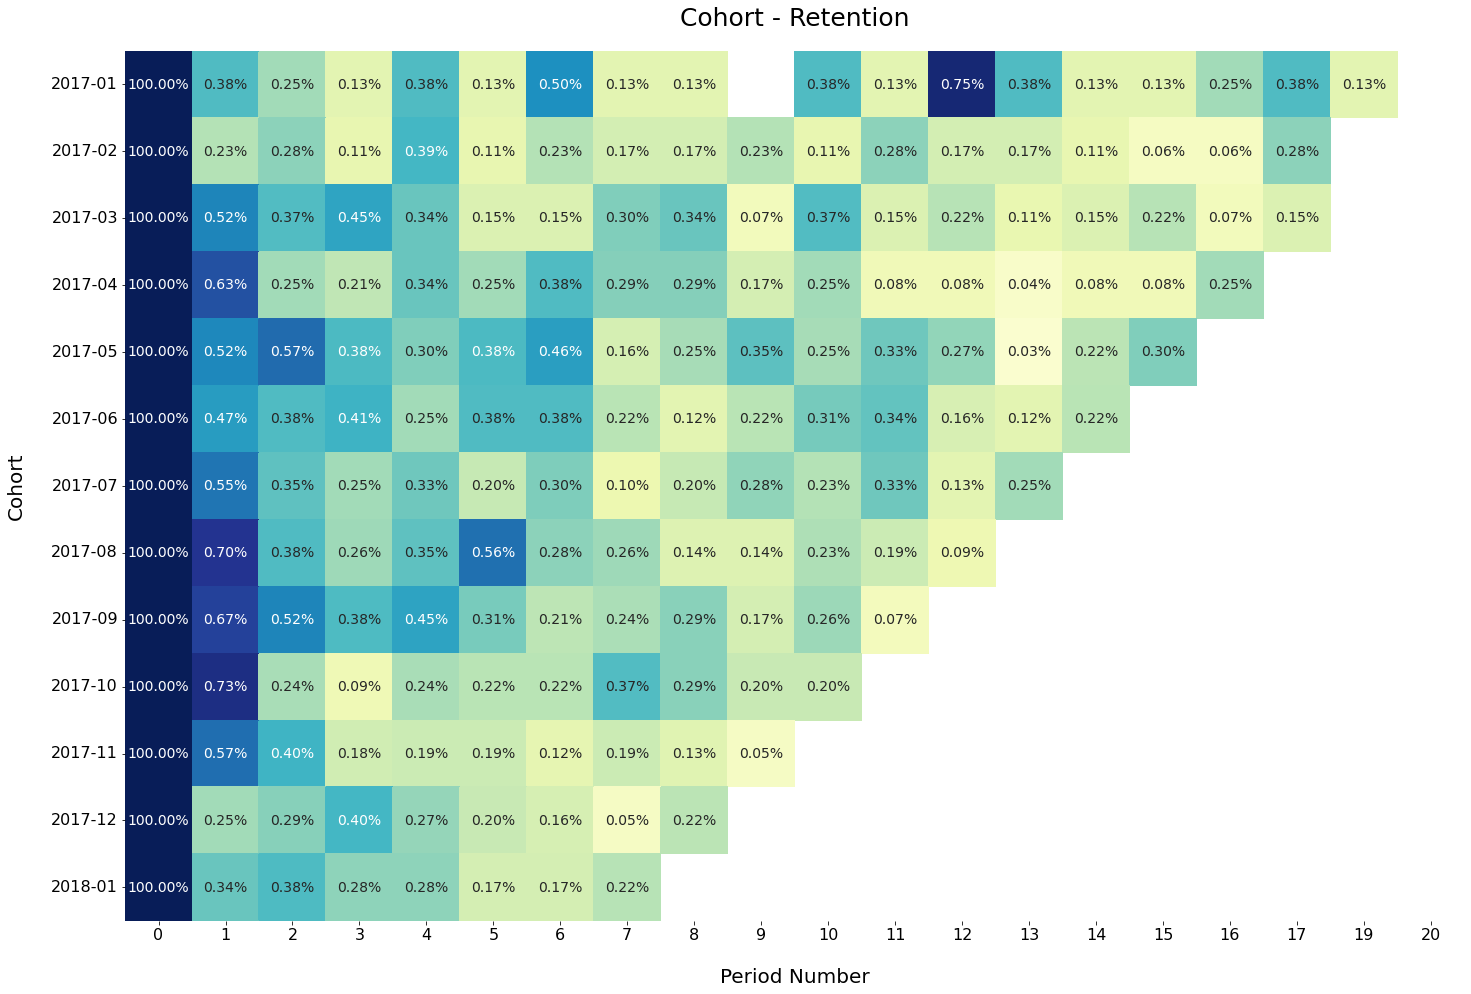

In [53]:
# Тепловая карта когортного анализа в период с января по декабрь 2017 года
plt.figure(figsize= (24, 16))
sns.heatmap(retention_matrix.loc['2017-01-01':'2018-01-31',],
                annot = True, 
                fmt = '.2%',
                vmin = 0.0,
                vmax = 0.008,
                cmap = 'YlGnBu',
                cbar=False,
                annot_kws={"fontsize":14})
plt.yticks(rotation=0)
plt.title('Cohort - Retention', fontsize = 25, pad=25) 
plt.xlabel('Period Number', fontsize = 20, labelpad=25)
plt.ylabel('Cohort', fontsize = 20, labelpad=25)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

# Ответ на задание 5: 
Когорта с самым высоким retention на 3-й месяц - "2017-05"


# Задание 6

In [54]:
# Соеденим датафреймы с покупателями и заказами

customer_orders = customers.merge(orders, how='inner', on='customer_id')

In [55]:
# Присоеденим датафрейм с товарами  

ecommerce_full = customer_orders.merge(goods, how='inner', on='order_id')

In [56]:
# Отберем необходимые столбцы и создадим новый датафрейм

ecommerce = ecommerce_full[['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'order_approved_at', 'product_id', 'price']]

In [57]:
ecommerce.head()

,customer_unique_id,order_id,order_purchase_timestamp,order_approved_at,product_id,price
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05-16 15:22:12,a9516a079e37a9c9c36b9b78b10169e8,124.99
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018-01-12 20:58:32,4aa6014eceb682077f9dc4bffebc05b0,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018-05-20 16:19:10,bd07b66896d6f1494f5b86251848ced7,139.94
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,2018-03-13 17:29:19,a5647c44af977b148e0a3a4751a09e2e,149.94
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,2018-07-29 10:10:09,9391a573abe00141c56e38d84d7d5b3b,230.00


In [58]:
# Так как, последняя дата в датафрейме была достаточно давно, для построение анализа будет использоваться день следующий за последним

final_date = ecommerce['order_approved_at'].max() + timedelta(days=1)

In [59]:
# Подсчитаем сумму покупок в одном заказе

ecommerce_mod = ecommerce.groupby(['customer_unique_id', 
                                   'order_id', 
                                   'order_approved_at'], as_index=False) \
                                    .agg({'price': 'sum'}) \
                                    .rename(columns={'price': 'total_sum'})

In [60]:
# Сгруппируем данные по id покупателя и посчитаем RFM-параметры

RFM = ecommerce_mod.groupby(['customer_unique_id'], as_index=False).agg({
                                                                    'order_approved_at': lambda x: (final_date - x.max()).days,
                                                                    'order_id': 'count',
                                                                    'total_sum': 'sum'})

In [61]:
# Переименуем столбцы

RFM.rename(columns={'order_approved_at': 'Recency', 'order_id': 'Frequency', 'total_sum': 'MonetaryValue'}, inplace=True)

In [62]:
RFM.head()

,customer_unique_id,Recency,Frequency,MonetaryValue
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f46a3911fa3c0805444483337064,542,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00


In [63]:
# Посмотрим описательную статистику для выбора значений по которым покупатели будут делиться на сегменты

RFM.describe()

,Recency,Frequency,MonetaryValue
count,95407.000000,95407.000000,95407.000000
mean,243.642626,1.034012,142.442098
std,153.126888,0.211225,217.667272
min,1.000000,1.000000,0.850000
25%,119.000000,1.000000,47.900000
50%,224.000000,1.000000,89.900000
75%,353.000000,1.000000,155.000000
max,719.000000,16.000000,13440.000000


In [64]:
# Задаем значения для деления покупателей на сегменты, за основу берутся квантили

r_bins = [0, 120, 350, 720]
f_bins = [0, 2, 5, 16] # Значения 2 и 5 выбраны на глазок
m_bins = [0, 48, 155, 13440]
RFM['R'] = pd.cut(RFM['Recency'], r_bins, labels = [3, 2, 1])
RFM['F'] = pd.cut(RFM['Frequency'], f_bins, labels = [1, 2, 3])
RFM['M'] = pd.cut(RFM['MonetaryValue'], m_bins, labels = [1, 2, 3])

In [65]:
# Через функцию создадим RFM-сегменты из данных в колонках R, F, M и поместим их в столбец RFM_group

def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
RFM['RFM_group'] = RFM.apply(join_rfm, axis=1)
RFM.head()

,customer_unique_id,Recency,Frequency,MonetaryValue,R,F,M,RFM_group
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,3,1,2,312
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,3,213


In [66]:
# Подсчитаем RFM_Score

RFM['RFM_Score'] = RFM[['R','F','M']].sum(axis=1)
RFM.head()

,customer_unique_id,Recency,Frequency,MonetaryValue,R,F,M,RFM_group,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,3,1,2,312,6
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3,1,1,311,5
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112,4
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1,211,4
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,3,213,6


In [67]:
# Количество уникальных сегментов
RFM_count_unique = RFM.groupby('RFM_group')['RFM_group'].nunique()
RFM_count_unique.sum()

19

In [68]:
# исходя из значений RFM_Score через функцию RFM_Level разаметим пользоватлелей на кластеры

# 'Fantasy' -  Это просто мечта, а не покупатели!
# 'Champion' - Покупатели - Чемпионы
# 'Loyal' - Лояльные покупатели
# 'Potential' - покупатели с хорошим потенциалом 
# 'Promising' - перспективные покупатели, но уступающие предыдущей группе
# 'Requires attention' - требующие внимания
# 'Demands Activation' - потерянные покупатели

def RFM_Level(df):
    if df['RFM_Score'] >= 9:
        return 'Fantasy'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champion'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Requires attention'
    else:
        return 'Demands Activation'
    
RFM['RFM_level'] = RFM.apply(RFM_Level, axis=1)  
RFM

,customer_unique_id,Recency,Frequency,MonetaryValue,R,F,M,RFM_group,RFM_Score,RFM_level
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,3,1,2,312,6,Potential
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3,1,1,311,5,Promising
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112,4,Requires attention
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1,211,4,Requires attention
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,3,213,6,Potential
...,...,...,...,...,...,...,...,...,...,...
95402,fffcf5a5ff07b0908bd4e2dbc735a684,452,1,1570.00,1,1,3,113,5,Promising
95403,fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89,2,1,2,212,5,Promising
95404,ffff371b4d645b6ecea244b27531430a,574,1,89.90,1,1,2,112,4,Requires attention
95405,ffff5962728ec6157033ef9805bacc48,125,1,115.00,2,1,2,212,5,Promising


In [69]:
# Функция по какой-то причине не работала, это был запасной вариант

# RFM.loc[(RFM.RFM_Score == 9), 'RFM_level'] = 'Fantasy'
# RFM.loc[(RFM.RFM_Score == 8), 'RFM_level'] = 'Champion'
# RFM.loc[(RFM.RFM_Score == 7), 'RFM_level'] = 'Loyal'
# RFM.loc[(RFM.RFM_Score == 6), 'RFM_level'] = 'Potential'
# RFM.loc[(RFM.RFM_Score == 5), 'RFM_level'] = 'Promising'
# RFM.loc[(RFM.RFM_Score == 4), 'RFM_level'] = 'Requires attention'
# RFM.loc[(RFM.RFM_Score == 3), 'RFM_level'] = 'Demands Activation'

In [70]:
# подсчитаем средние значения метрик R, F, M для каждого кластера и подсчитаем количество покупателей в каждом кластере

RFM_level_agg = RFM.groupby('RFM_level', as_index=False).agg({
                                                            'Recency': 'mean',
                                                            'Frequency': 'mean',
                                                            'MonetaryValue': 'mean',
                                                            'customer_unique_id': 'count'
                                                            }).round(2)

In [71]:
# Переименуем столбцы и отсортируем

RFM_level_agg.columns = ['RFM_level', 'Recency_mean','Frequency_ mean','Monetary_mean', 'Count']
RFM_level_agg.sort_values('Count', ascending=False)

,RFM_level,Recency_mean,Frequency_ mean,Monetary_mean,Count
5,Promising,238.19,1.02,127.68,35723
4,Potential,144.41,1.05,218.44,23695
6,Requires attention,340.35,1.01,59.71,23629
1,Demands Activation,460.05,1.01,29.17,6226
3,Loyal,66.51,1.11,365.76,6059
0,Champion,70.23,3.53,580.70,70
2,Fantasy,57.40,8.40,693.60,5
